# Macro Announcement Effects — Visualization & Diagnostics

This notebook explores the processed macro-announcement dataset and associated event study results to produce diagnostic plots and interactive visuals that complement the automated pipeline outputs.

## Workflow Overview

1. Load configuration, metadata, and pre-computed event study summaries.
2. Visualize cross-asset cumulative abnormal returns (CARs) and dispersion patterns.
3. Sample the aligned panel dataset to inspect behaviour across representative assets.
4. Build correlation, rolling relationship, and distribution plots for deeper diagnostics.

In [1]:
# Core imports
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
sns.set_theme(style="whitegrid")

In [2]:
# Path configuration
PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"

ALIGNED_DATA_PATH = PROCESSED_DIR / "aligned_data.csv"
METADATA_PATH = PROCESSED_DIR / "data_metadata.json"
EVENT_SUMMARY_PATH = RESULTS_DIR / "event_study_summary.csv"
EVENT_DETAILS_DIR = RESULTS_DIR / "tables" / "event_study"

print(f"Project root: {PROJECT_ROOT}")
print(f"Aligned data available: {ALIGNED_DATA_PATH.exists()}")
print(f"Event summary available: {EVENT_SUMMARY_PATH.exists()}")

Project root: D:\Works\Researchs\macro-announcement-effect
Aligned data available: True
Event summary available: True


In [3]:
# Load metadata for quick reference
with METADATA_PATH.open() as fh:
    metadata = json.load(fh)

variable_categories = metadata.get("variable_categories", {})
print("Rows, Columns:", metadata.get("data_shape"))
print("Variable groups:", list(variable_categories.keys())[:8], "...")
metadata.get("date_range", {})

Rows, Columns: [1854, 3421]
Variable groups: ['stock_prices', 'crypto_prices', 'economic_indicators', 'returns', 'volatilities', 'surprises'] ...


{'start': '2020-09-01 00:00:00',
 'end': '2025-09-28 00:00:00',
 'total_days': 1854}

In [4]:
# Helper utilities for sampling and reshaping
def get_category_columns(category: str, limit: int | None = 10) -> list[str]:
    columns = variable_categories.get(category, [])
    if limit is None:
        return columns
    return columns[:limit]


def load_aligned_data_subset(columns: list[str], n_rows: int = 5000) -> pd.DataFrame:
    if not ALIGNED_DATA_PATH.exists():
        raise FileNotFoundError(f"Missing processed dataset at {ALIGNED_DATA_PATH}")

    includes_date = "date" in columns
    requested_columns = [col for col in columns if col != "date"]

    available_columns = pd.read_csv(ALIGNED_DATA_PATH, nrows=0).columns.tolist()

    date_column_in_file: str | None = None
    if includes_date:
        for candidate in ("date", "Date", "DATE", "timestamp", "Timestamp", "Unnamed: 0", "index"):
            if candidate in available_columns:
                date_column_in_file = candidate
                break
        if date_column_in_file is None:
            raise KeyError(
                "Missing a date or index column in aligned data; searched for "
                "['date', 'Date', 'DATE', 'timestamp', 'Timestamp', 'Unnamed: 0', 'index']."
            )

    missing = [col for col in requested_columns if col not in available_columns]
    if missing:
        raise KeyError(f"Missing columns in aligned data: {missing}")

    read_columns = requested_columns.copy()
    if includes_date and date_column_in_file is not None:
        read_columns = [date_column_in_file] + read_columns

    df = pd.read_csv(ALIGNED_DATA_PATH, usecols=read_columns, nrows=n_rows)

    if includes_date and date_column_in_file is not None:
        df = df.rename(columns={date_column_in_file: "date"})
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.set_index("date").sort_index()

    return df


def augment_event_summary(df: pd.DataFrame) -> pd.DataFrame:
    expanded = df.copy()
    expanded["category"] = expanded.index.str.split("_", n=1).str[0]
    expanded["metric"] = expanded.index.str.split("_", n=1).str[1]
    return expanded

In [5]:
# Event study summary overview
event_summary = pd.read_csv(EVENT_SUMMARY_PATH, index_col=0)
display(event_summary.head())
event_summary_aug = augment_event_summary(event_summary)
display(event_summary_aug.head())

,mean_car,median_car,std_car,min_car,max_car,positive_events,negative_events,total_events
stocks_SP500_cumret_1d,-2.478176e-17,-5.551115e-17,6.152536e-17,-8.326673e-17,8.326673e-17,2.0,4.0,7.0
stocks_SP500_skewness_20d,1.996346e-02,7.675927e-03,7.756161e-02,-4.492018e-02,1.094221e-01,2.0,2.0,4.0
stocks_DJI_skewness_20d,-4.397975e-02,-6.416101e-02,1.770088e-01,-3.215942e-01,1.556173e-01,2.0,4.0,6.0
stocks_RUSSELL2000_kurtosis_10d,4.003108e-02,2.003268e-02,4.925633e-02,8.097282e-03,1.119617e-01,4.0,0.0,4.0
stocks_SPY_ETF_cumret_1d,-7.825121e-03,-2.995987e-02,5.438181e-02,-7.282685e-02,6.489785e-02,2.0,3.0,5.0


,mean_car,median_car,std_car,min_car,max_car,positive_events,negative_events,total_events,category,metric
stocks_SP500_cumret_1d,-2.478176e-17,-5.551115e-17,6.152536e-17,-8.326673e-17,8.326673e-17,2.0,4.0,7.0,stocks,SP500_cumret_1d
stocks_SP500_skewness_20d,1.996346e-02,7.675927e-03,7.756161e-02,-4.492018e-02,1.094221e-01,2.0,2.0,4.0,stocks,SP500_skewness_20d
stocks_DJI_skewness_20d,-4.397975e-02,-6.416101e-02,1.770088e-01,-3.215942e-01,1.556173e-01,2.0,4.0,6.0,stocks,DJI_skewness_20d
stocks_RUSSELL2000_kurtosis_10d,4.003108e-02,2.003268e-02,4.925633e-02,8.097282e-03,1.119617e-01,4.0,0.0,4.0,stocks,RUSSELL2000_kurtosis_10d
stocks_SPY_ETF_cumret_1d,-7.825121e-03,-2.995987e-02,5.438181e-02,-7.282685e-02,6.489785e-02,2.0,3.0,5.0,stocks,SPY_ETF_cumret_1d


In [6]:
# Top positive and negative mean CAR contributions
top_n = 15
sorted_summary = event_summary.sort_values("mean_car", ascending=False)
top_positive = sorted_summary.head(top_n).assign(direction="positive")
top_negative = event_summary.sort_values("mean_car").head(top_n).assign(direction="negative")
combined = pd.concat([top_positive, top_negative])
combined = combined.reset_index().rename(columns={"index": "series"})

fig = px.bar(
    combined,
    x="mean_car",
    y="series",
    color="direction",
    orientation="h",
    text="mean_car",
    color_discrete_map={"positive": "#2ca02c", "negative": "#d62728"},
    title=f"Top ±{top_n} Mean CAR Effects"
)
fig.update_layout(yaxis_title="Series", xaxis_title="Mean CAR", legend_title="Direction")
fig.update_traces(texttemplate="%{x:.3f}", textposition="outside")
fig.show()

In [7]:
# Dispersion of CARs by standard deviation and frequency
scatter_df = event_summary_aug.reset_index().rename(columns={"index": "series"})
fig = px.scatter(
    scatter_df,
    x="std_car",
    y="mean_car",
    size="total_events",
    color="category",
    hover_data={"series": True, "median_car": ":.3f", "positive_events": True, "negative_events": True},
    title="Event Study Dispersion"
)
fig.update_layout(xaxis_title="Standard Deviation of CAR", yaxis_title="Mean CAR")
fig.show()

In [8]:
# Category-level summary statistics
category_summary = event_summary_aug.groupby("category")["mean_car"].agg(["mean", "median", "std", "count"]).sort_values("mean", ascending=False)
display(category_summary)
fig = px.box(
    event_summary_aug,
    x="category",
    y="mean_car",
    points="suspectedoutliers",
    title="Distribution of Mean CAR by Category"
)
fig.update_layout(xaxis_title="Category", yaxis_title="Mean CAR")
fig.show()

,mean,median,std,count
category,,,,
economic,0.071487,0.091067,0.036572,21
high,0.044025,0.044025,NaN,1
crypto,0.027406,0.005301,0.107106,166
stocks,0.027296,0.013042,0.089315,191
fixed,0.016607,0.006103,0.065862,132
volatility,0.011694,0.012789,0.105540,48
bull,0.000000,0.000000,NaN,1
low,0.000000,0.000000,NaN,1
bear,-0.004099,-0.004099,NaN,1


In [9]:
# Sample representative series from the aligned panel
selected_series = [
    "stocks_SP500_cumret_1d",
    "stocks_VIX_cumret_10d",
    "crypto_Bitcoin_cumret_1d",
    "fixed_income_Treasury_10Y_Yield_cumret_1d",
]
aligned_sample = load_aligned_data_subset(["date"] + selected_series, n_rows=5000)
display(aligned_sample.head())
aligned_sample[selected_series].describe()

,stocks_SP500_cumret_1d,stocks_VIX_cumret_10d,crypto_Bitcoin_cumret_1d,fixed_income_Treasury_10Y_Yield_cumret_1d
date,,,,
2020-09-01,NaN,NaN,NaN,NaN
2020-09-02,0.015249,0.017081,-0.047600,-0.031749
2020-09-03,-0.035758,0.251825,-0.108025,-0.045570
2020-09-04,-0.008166,0.163189,0.025681,0.147699
2020-09-05,0.000000,0.163189,-0.033100,0.000000


,stocks_SP500_cumret_1d,stocks_VIX_cumret_10d,crypto_Bitcoin_cumret_1d,fixed_income_Treasury_10Y_Yield_cumret_1d
count,1853.000000,1853.000000,1853.000000,1853.000000
mean,0.000342,-0.002720,0.001207,0.000987
std,0.009023,0.171349,0.030964,0.020076
min,-0.061609,-0.929208,-0.174053,-0.138402
25%,-0.001872,-0.100279,-0.012831,-0.005823
50%,0.000000,-0.007323,0.000415,0.000000
75%,0.003602,0.086501,0.015125,0.008312
max,0.090895,0.971530,0.171821,0.155543


In [10]:
# Multi-series line chart for selected assets
line_df = aligned_sample.reset_index().rename(columns={"index": "date"})
fig = px.line(
    line_df,
    x="date",
    y=selected_series,
    title="Selected Series: Cumulative Returns Snapshot",
)
fig.update_layout(legend_title="Series", xaxis_title="Date", yaxis_title="Value")
fig.show()

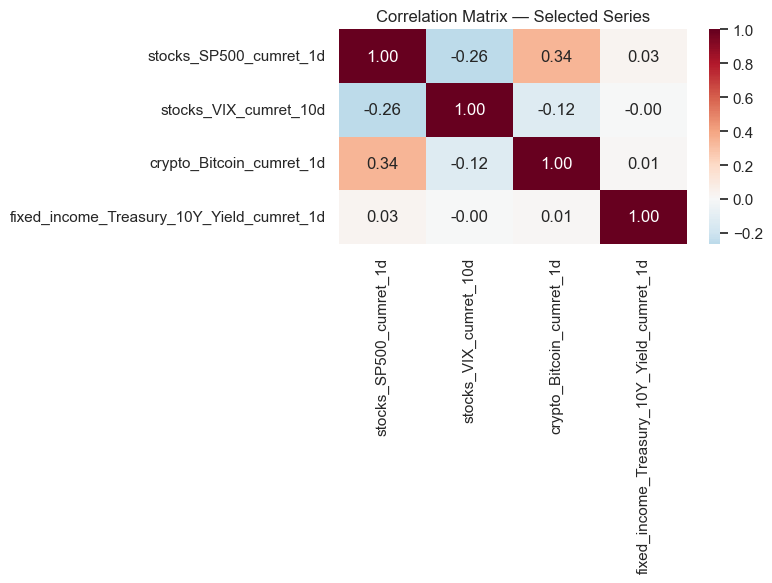

In [11]:
# Correlation matrix for the selected series
corr = aligned_sample[selected_series].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="RdBu_r", center=0, fmt=".2f")
plt.title("Correlation Matrix — Selected Series")
plt.tight_layout()
plt.show()

In [12]:
# Rolling correlation against SP500 benchmark
window = 90
anchor = "stocks_SP500_cumret_1d"
rolling_corr = pd.DataFrame({
    series: aligned_sample[anchor].rolling(window).corr(aligned_sample[series])
    for series in selected_series
    if series != anchor
})
rolling_corr.index = aligned_sample.index
fig = px.line(
    rolling_corr.reset_index().rename(columns={"index": "date"}),
    x="date",
    y=rolling_corr.columns,
    title=f"{window}-Day Rolling Correlation vs {anchor}",
)
fig.update_layout(yaxis_title="Correlation", xaxis_title="Date")
fig.show()

## Next Steps

- Swap `selected_series` for alternative groups (e.g., crypto volatility, macro indicators) to replicate the diagnostics.
- Export figures or tables by calling `fig.write_html(...)` / `fig.write_image(...)` if static artefacts are required.
- Integrate notebook outputs back into the reporting pipeline by checking data saved under `results/tables/`.

## Deep Dive: Statistical Significance Analysis

Examine the statistical significance of event study results and identify robust patterns.

In [13]:
# Statistical significance of CAR effects
from scipy import stats

# Calculate t-statistics for mean CARs
event_summary_aug["t_statistic"] = event_summary_aug["mean_car"] / (event_summary_aug["std_car"] / np.sqrt(event_summary_aug["total_events"]))
event_summary_aug["p_value"] = 2 * (1 - stats.t.cdf(np.abs(event_summary_aug["t_statistic"]), event_summary_aug["total_events"] - 1))
event_summary_aug["significant_5pct"] = event_summary_aug["p_value"] < 0.05
event_summary_aug["significant_1pct"] = event_summary_aug["p_value"] < 0.01

# Summary of statistical significance
sig_summary = pd.DataFrame({
    "Total Series": [len(event_summary_aug)],
    "Significant at 5%": [event_summary_aug["significant_5pct"].sum()],
    "Significant at 1%": [event_summary_aug["significant_1pct"].sum()],
    "Pct Significant (5%)": [100 * event_summary_aug["significant_5pct"].mean()],
    "Pct Significant (1%)": [100 * event_summary_aug["significant_1pct"].mean()]
})
display(sig_summary)

# Show most statistically significant results
top_significant = event_summary_aug.nlargest(20, "t_statistic")[["mean_car", "std_car", "total_events", "t_statistic", "p_value", "category"]]
display(top_significant)

,Total Series,Significant at 5%,Significant at 1%,Pct Significant (5%),Pct Significant (1%)
0,564,62,22,10.992908,3.900709


,mean_car,std_car,total_events,t_statistic,p_value,category
volatility_VIX_ETN_skewness_5d,0.179750,0.000000,2.0,inf,0.000000,volatility
volatility_VIX_ETN_cumret_5d,0.213576,0.000000,2.0,inf,0.000000,volatility
fixed_income_Treasury_10Y_Yield_cumret_5d,0.024620,0.000000,2.0,inf,0.000000,fixed
fixed_income_Treasury_30Y_Yield_cumret_5d,0.138141,0.000000,2.0,inf,0.000000,fixed
fixed_income_Investment_Grade_Bonds_skewness_10d,0.022275,0.000000,2.0,inf,0.000000,fixed
stocks_DJI_skewness_10d,0.190486,0.000190,2.0,1418.224876,0.000449,stocks
crypto_Binance_Coin_kurtosis_10d,0.261147,0.004760,2.0,77.584184,0.008205,crypto
crypto_Chainlink_kurtosis_10d,0.143802,0.008260,2.0,24.619715,0.025844,crypto
crypto_Binance_Coin_cumret_10d,0.252961,0.028677,3.0,15.278758,0.004256,crypto
volatility_VIX_ETN_skewness_20d,0.145463,0.017745,3.0,14.198303,0.004924,volatility


In [14]:
# Visualize significance by category
sig_by_category = event_summary_aug.groupby("category").agg({
    "significant_5pct": "sum",
    "total_events": "sum"
}).reset_index()
sig_by_category["pct_significant"] = 100 * sig_by_category["significant_5pct"] / sig_by_category["total_events"]

fig = px.bar(
    sig_by_category.sort_values("pct_significant", ascending=False),
    x="category",
    y="pct_significant",
    text="pct_significant",
    title="Statistical Significance Rate by Category (5% level)"
)
fig.update_traces(texttemplate="%{y:.1f}%", textposition="outside")
fig.update_layout(xaxis_title="Category", yaxis_title="% Significant Events")
fig.show()

## Event Asymmetry Analysis

Analyze whether positive and negative events have symmetric or asymmetric effects.

In [15]:
# Calculate positive vs negative event ratios and magnitudes
event_summary_aug["pos_neg_ratio"] = event_summary_aug["positive_events"] / (event_summary_aug["negative_events"] + 1e-6)
event_summary_aug["asymmetry_score"] = np.abs(event_summary_aug["positive_events"] - event_summary_aug["negative_events"]) / event_summary_aug["total_events"]

# Identify highly asymmetric series
asymmetric_series = event_summary_aug[event_summary_aug["asymmetry_score"] > 0.6].sort_values("asymmetry_score", ascending=False)
display(asymmetric_series[["mean_car", "positive_events", "negative_events", "asymmetry_score", "category"]].head(15))

# Visualization of asymmetry
fig = px.scatter(
    event_summary_aug.reset_index().rename(columns={"index": "series"}),
    x="positive_events",
    y="negative_events",
    color="mean_car",
    size="total_events",
    hover_data={"series": True, "asymmetry_score": ":.2f"},
    title="Event Asymmetry: Positive vs Negative Events",
    color_continuous_scale="RdYlGn"
)
# Add diagonal reference line
max_events = max(event_summary_aug["positive_events"].max(), event_summary_aug["negative_events"].max())
fig.add_shape(type="line", x0=0, y0=0, x1=max_events, y1=max_events, 
              line=dict(color="gray", dash="dash"))
fig.update_layout(xaxis_title="Positive Events", yaxis_title="Negative Events")
fig.show()

,mean_car,positive_events,negative_events,asymmetry_score,category
stocks_RUSSELL2000_kurtosis_10d,0.040031,4.0,0.0,1.0,stocks
stocks_VIX_skewness_5d,-0.078508,0.0,2.0,1.0,stocks
stocks_OIL_kurtosis_5d,-0.047886,0.0,5.0,1.0,stocks
crypto_Binance_Coin_cumret_10d,0.252961,3.0,0.0,1.0,crypto
crypto_Binance_Coin_kurtosis_20d,0.095074,5.0,0.0,1.0,crypto
fixed_income_Treasury_10Y_Yield_kurtosis_20d,0.153552,3.0,0.0,1.0,fixed
crypto_Ripple_skewness_20d,-0.109258,0.0,5.0,1.0,crypto
volatility_VIX_Index_skewness_5d,-0.078508,0.0,2.0,1.0,volatility
volatility_VIX_ETN_skewness_5d,0.179750,2.0,0.0,1.0,volatility
volatility_VIX_ETN_cumret_5d,0.213576,2.0,0.0,1.0,volatility


## Time Series Decomposition & Distribution Analysis

Examine the distributional properties and temporal patterns of selected series.

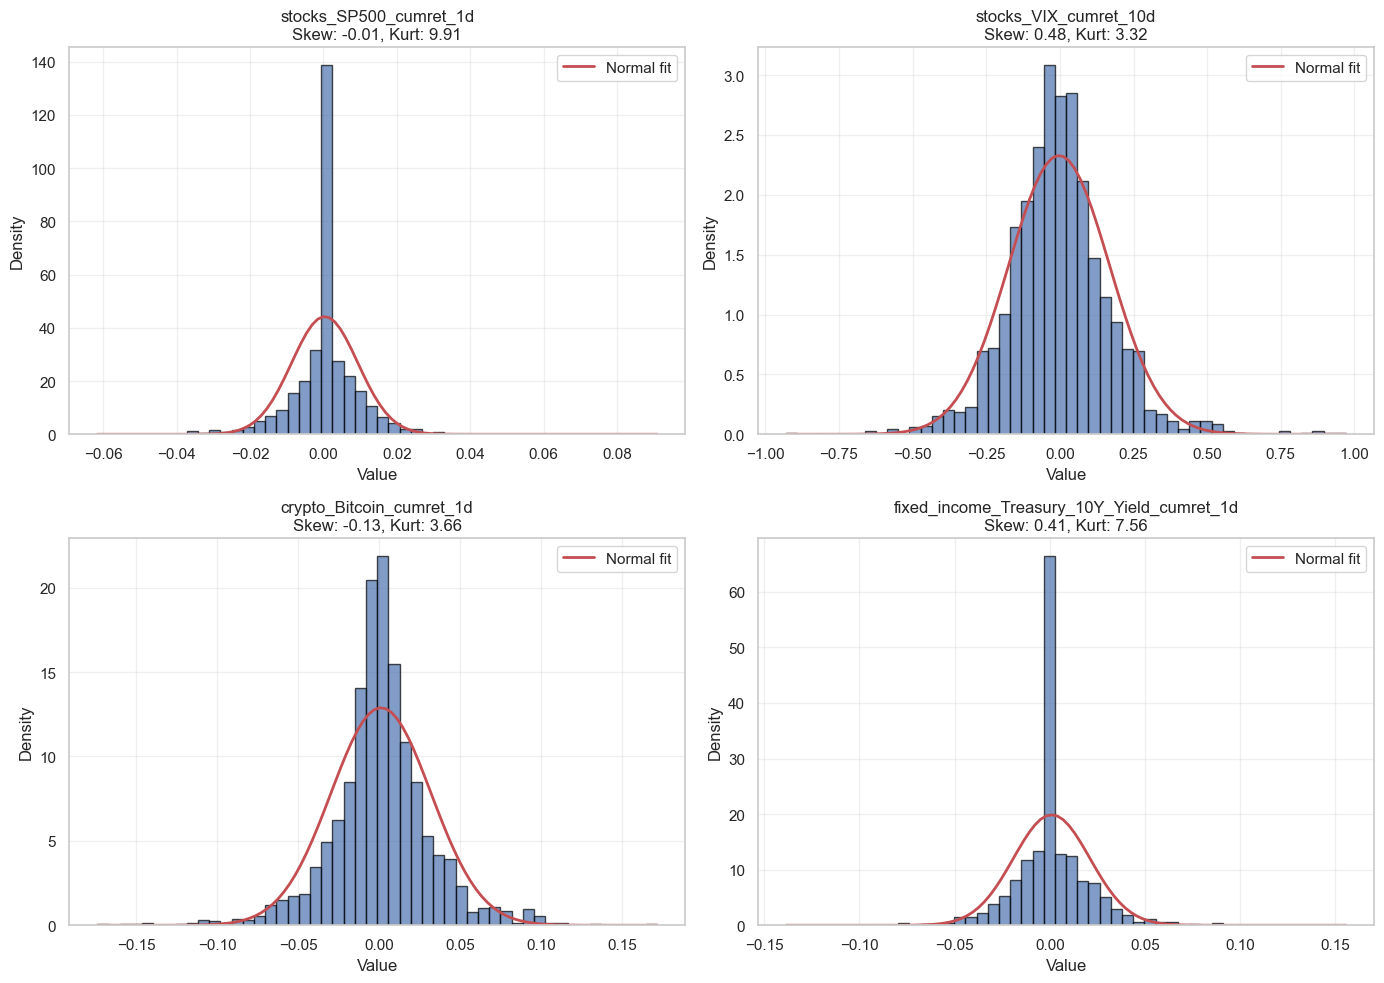


Normality Tests (Jarque-Bera):
stocks_SP500_cumret_1d: JB=7574.85, p-value=0.0000 [Non-Normal]
stocks_VIX_cumret_10d: JB=921.07, p-value=0.0000 [Non-Normal]
crypto_Bitcoin_cumret_1d: JB=1039.05, p-value=0.0000 [Non-Normal]
fixed_income_Treasury_10Y_Yield_cumret_1d: JB=4462.26, p-value=0.0000 [Non-Normal]


In [16]:
# Distribution analysis for selected series
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, series in enumerate(selected_series):
    ax = axes[idx]
    data = aligned_sample[series].dropna()
    
    # Histogram with KDE
    ax.hist(data, bins=50, alpha=0.7, density=True, edgecolor='black')
    
    # Overlay normal distribution
    mu, std = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 100)
    ax.plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2, label='Normal fit')
    
    # Statistics
    skew = stats.skew(data)
    kurt = stats.kurtosis(data)
    
    ax.set_title(f"{series}\nSkew: {skew:.2f}, Kurt: {kurt:.2f}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests for normality
print("\nNormality Tests (Jarque-Bera):")
for series in selected_series:
    data = aligned_sample[series].dropna()
    jb_stat, jb_pval = stats.jarque_bera(data)
    print(f"{series}: JB={jb_stat:.2f}, p-value={jb_pval:.4f} {'[Normal]' if jb_pval > 0.05 else '[Non-Normal]'}")

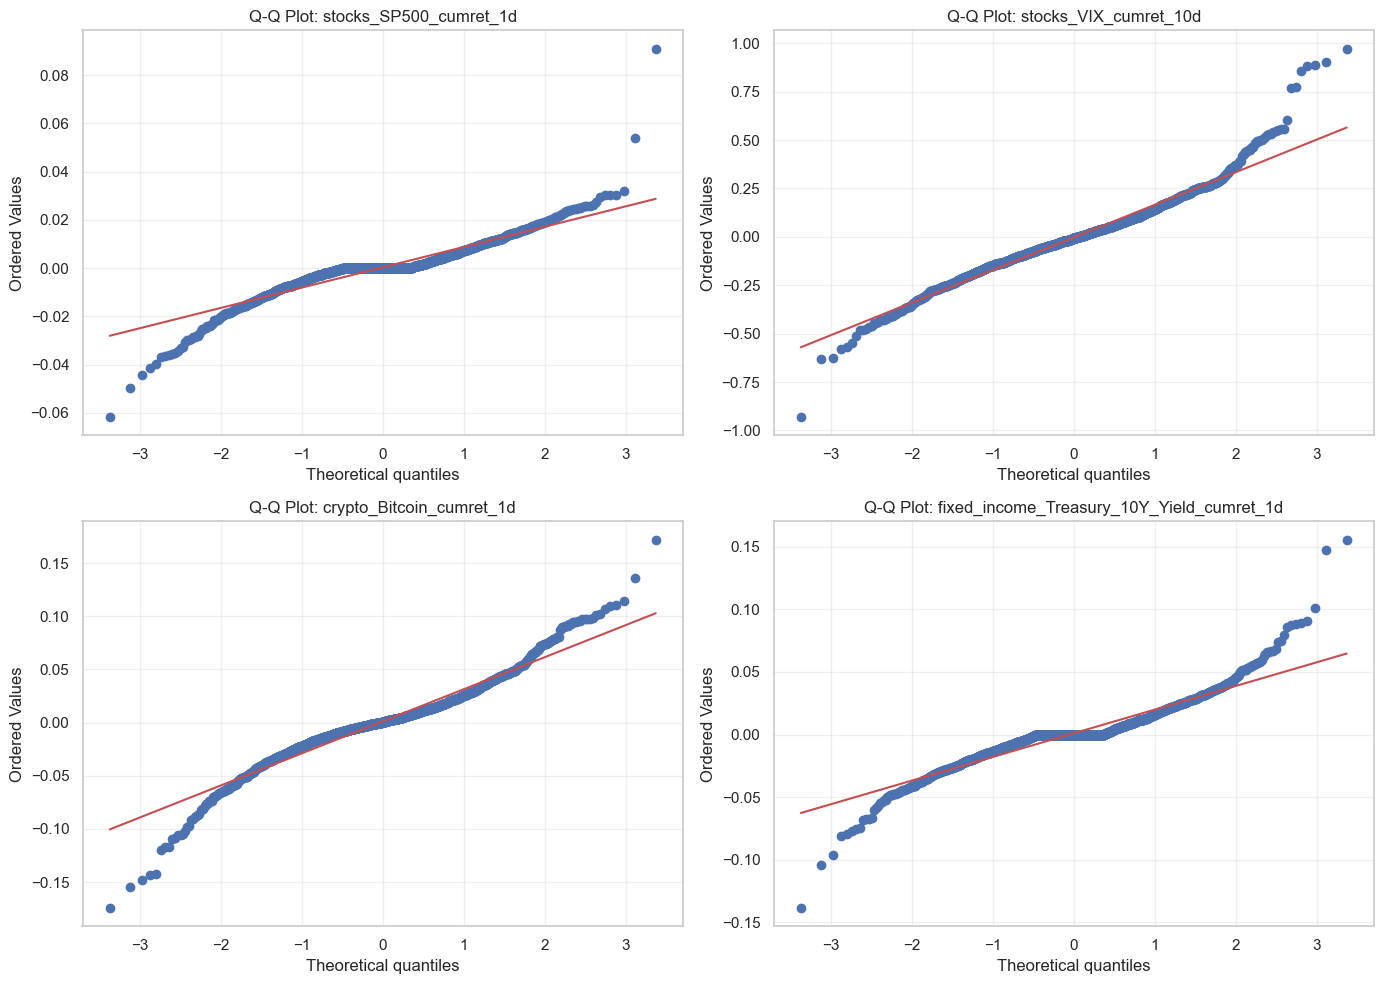

In [17]:
# Q-Q plots for normality assessment
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, series in enumerate(selected_series):
    ax = axes[idx]
    data = aligned_sample[series].dropna()
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(f"Q-Q Plot: {series}")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Cross-Category Comparison

Compare event study results across different asset categories to identify systematic patterns.

In [18]:
# Detailed category statistics
category_detailed = event_summary_aug.groupby("category").agg({
    "mean_car": ["mean", "median", "std", "min", "max"],
    "std_car": ["mean", "median"],
    "total_events": ["sum", "mean"],
    "positive_events": "sum",
    "negative_events": "sum"
}).round(4)

category_detailed.columns = ["_".join(col).strip() for col in category_detailed.columns.values]
display(category_detailed.sort_values("mean_car_mean", ascending=False))

# Violin plot for distribution comparison
fig = go.Figure()
for category in event_summary_aug["category"].unique():
    cat_data = event_summary_aug[event_summary_aug["category"] == category]["mean_car"]
    fig.add_trace(go.Violin(
        y=cat_data,
        name=category,
        box_visible=True,
        meanline_visible=True
    ))

fig.update_layout(
    title="Distribution of Mean CAR by Category (Violin Plot)",
    yaxis_title="Mean CAR",
    xaxis_title="Category",
    showlegend=False
)
fig.show()

,mean_car_mean,mean_car_median,mean_car_std,mean_car_min,mean_car_max,std_car_mean,std_car_median,total_events_sum,total_events_mean,positive_events_sum,negative_events_sum
category,,,,,,,,,,,
economic,0.0715,0.0911,0.0366,0.0101,0.1217,0.0711,0.0702,80.0,3.8095,65.0,15.0
high,0.0440,0.0440,NaN,0.0440,0.0440,0.1303,0.1303,5.0,5.0000,4.0,1.0
crypto,0.0274,0.0053,0.1071,-0.3894,0.3865,0.1022,0.0705,690.0,4.1566,321.0,369.0
stocks,0.0273,0.0130,0.0893,-0.2933,0.3068,0.0858,0.0701,850.0,4.4503,437.0,412.0
fixed,0.0166,0.0061,0.0659,-0.1230,0.2792,0.0896,0.0760,640.0,4.8485,288.0,352.0
volatility,0.0117,0.0128,0.1055,-0.3361,0.2136,0.0883,0.0850,206.0,4.2917,114.0,92.0
bull,0.0000,0.0000,NaN,0.0000,0.0000,0.0000,0.0000,2.0,2.0000,0.0,0.0
low,0.0000,0.0000,NaN,0.0000,0.0000,NaN,NaN,1.0,1.0000,0.0,0.0
bear,-0.0041,-0.0041,NaN,-0.0041,-0.0041,0.1590,0.1590,3.0,3.0000,2.0,1.0


## Volatility and Risk Metrics Analysis

Analyze volatility patterns and risk characteristics across different time windows.

In [19]:
# Calculate rolling volatility for selected series
windows = [30, 60, 90]
volatility_data = {}

for window in windows:
    vol_df = aligned_sample[selected_series].rolling(window).std()
    volatility_data[f"{window}d"] = vol_df

# Plot rolling volatility for first series
benchmark_series = selected_series[0]
vol_comparison = pd.DataFrame({
    f"{window}d": volatility_data[f"{window}d"][benchmark_series]
    for window in windows
})

fig = px.line(
    vol_comparison.reset_index().rename(columns={"index": "date"}),
    x="date",
    y=vol_comparison.columns,
    title=f"Rolling Volatility Comparison: {benchmark_series}"
)
fig.update_layout(yaxis_title="Standard Deviation", xaxis_title="Date", legend_title="Window")
fig.show()

In [20]:
# Risk metrics: VaR and CVaR (Expected Shortfall)
confidence_levels = [0.95, 0.99]
risk_metrics = []

for series in selected_series:
    data = aligned_sample[series].dropna()
    metrics = {"series": series}
    
    for conf in confidence_levels:
        var = np.percentile(data, (1 - conf) * 100)
        cvar = data[data <= var].mean()
        metrics[f"VaR_{int(conf*100)}"] = var
        metrics[f"CVaR_{int(conf*100)}"] = cvar
    
    # Additional metrics
    metrics["sharpe_approx"] = data.mean() / data.std() if data.std() > 0 else 0
    metrics["max_drawdown"] = (data.cumsum() - data.cumsum().cummax()).min()
    
    risk_metrics.append(metrics)

risk_df = pd.DataFrame(risk_metrics)
display(risk_df.round(4))

# Visualize VaR comparison
fig = go.Figure()
fig.add_trace(go.Bar(
    name="VaR 95%",
    x=risk_df["series"],
    y=risk_df["VaR_95"],
    marker_color="orange"
))
fig.add_trace(go.Bar(
    name="VaR 99%",
    x=risk_df["series"],
    y=risk_df["VaR_99"],
    marker_color="red"
))
fig.update_layout(
    title="Value at Risk Comparison",
    xaxis_title="Series",
    yaxis_title="VaR",
    barmode="group"
)
fig.show()

,series,VaR_95,CVaR_95,VaR_99,CVaR_99,sharpe_approx,max_drawdown
0,stocks_SP500_cumret_1d,-0.0146,-0.0226,-0.0283,-0.0365,0.0379,-0.2934
1,stocks_VIX_cumret_10d,-0.2635,-0.3623,-0.4191,-0.5157,-0.0159,-10.8854
2,crypto_Bitcoin_cumret_1d,-0.0481,-0.0732,-0.0887,-0.1168,0.0390,-1.4539
3,fixed_income_Treasury_10Y_Yield_cumret_1d,-0.0296,-0.0452,-0.0512,-0.0729,0.0492,-0.3969


## Advanced Correlation Analysis

Explore dynamic correlations and lead-lag relationships between series.

In [21]:
# Cross-correlation analysis with lags
from scipy.signal import correlate

def compute_cross_correlation(s1, s2, max_lag=20):
    """Compute cross-correlation between two series with different lags."""
    s1_clean = s1.dropna()
    s2_clean = s2.dropna()
    
    # Align series
    common_idx = s1_clean.index.intersection(s2_clean.index)
    s1_aligned = s1_clean.loc[common_idx]
    s2_aligned = s2_clean.loc[common_idx]
    
    # Normalize
    s1_norm = (s1_aligned - s1_aligned.mean()) / s1_aligned.std()
    s2_norm = (s2_aligned - s2_aligned.mean()) / s2_aligned.std()
    
    # Compute cross-correlation
    lags = range(-max_lag, max_lag + 1)
    correlations = []
    
    for lag in lags:
        if lag < 0:
            corr = np.corrcoef(s1_norm[:lag], s2_norm[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(s1_norm[lag:], s2_norm[:-lag])[0, 1]
        else:
            corr = np.corrcoef(s1_norm, s2_norm)[0, 1]
        correlations.append(corr)
    
    return list(lags), correlations

# Analyze lead-lag relationship between SP500 and VIX
s1 = aligned_sample["stocks_SP500_cumret_1d"]
s2 = aligned_sample["stocks_VIX_cumret_10d"]
lags, corrs = compute_cross_correlation(s1, s2, max_lag=20)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=lags, 
    y=corrs,
    hoverinfo='none'
))
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(
    title="Cross-Correlation: SP500 vs VIX (with lags)",
    xaxis_title="Lag (days, negative = SP500 leads)",
    yaxis_title="Correlation",
    hovermode=False
)
fig.show()

In [22]:
# Dynamic Conditional Correlation (DCC) approximation using rolling windows
window_sizes = [30, 60, 90, 180]
pair1, pair2 = selected_series[0], selected_series[2]  # SP500 vs Bitcoin

fig = go.Figure()
for window in window_sizes:
    rolling_corr = aligned_sample[pair1].rolling(window).corr(aligned_sample[pair2])
    fig.add_trace(go.Scatter(
        x=rolling_corr.index,
        y=rolling_corr.values,
        mode="lines",
        name=f"{window}d window"
    ))

fig.update_layout(
    title=f"Dynamic Correlation: {pair1} vs {pair2}",
    xaxis_title="Date",
    yaxis_title="Correlation",
    legend_title="Window Size"
)
fig.show()

## Event Window Analysis Deep Dive

Load and analyze detailed event window data to understand short-term vs long-term effects.

In [23]:
# Load detailed event study results if available
try:
    event_details_files = list(EVENT_DETAILS_DIR.glob("*.csv"))
    if event_details_files:
        # Load first available detailed results
        sample_event_file = event_details_files[0]
        event_details = pd.read_csv(sample_event_file)
        print(f"Loaded: {sample_event_file.name}")
        print(f"Shape: {event_details.shape}")
        display(event_details.head(10))
        
        # Analyze event window patterns if relevant columns exist
        if "event_window" in event_details.columns and "car" in event_details.columns:
            window_analysis = event_details.groupby("event_window")["car"].agg([
                "count", "mean", "median", "std", "min", "max"
            ])
            display(window_analysis)
            
            # Visualization
            fig = px.box(
                event_details,
                x="event_window",
                y="car",
                title=f"CAR Distribution by Event Window: {sample_event_file.stem}"
            )
            fig.update_layout(xaxis_title="Event Window", yaxis_title="CAR")
            fig.show()
    else:
        print("No detailed event study files found in", EVENT_DETAILS_DIR)
except Exception as e:
    print(f"Could not load detailed event data: {e}")

Loaded: average_abnormal_returns.csv
Shape: (2, 572)


,event_time,stocks_SP500_cumret_1d,stocks_SP500_skewness_20d,stocks_DJI_skewness_20d,stocks_RUSSELL2000_kurtosis_10d,stocks_SPY_ETF_cumret_1d,stocks_SPY_ETF_skewness_20d,stocks_QQQ_ETF_kurtosis_10d,stocks_VTI_ETF_cumret_1d,stocks_VTI_ETF_skewness_20d,stocks_VIX_skewness_5d,stocks_VIX_kurtosis_20d,stocks_OIL_kurtosis_5d,stocks_OIL_cumret_5d,stocks_OIL_skewness_20d,stocks_OIL_cumret_20d,crypto_Bitcoin_kurtosis_20d,crypto_Ethereum_kurtosis_20d,crypto_Binance_Coin_kurtosis_5d,crypto_Binance_Coin_cumret_10d,crypto_Binance_Coin_kurtosis_20d,crypto_Ripple_skewness_10d,crypto_Ripple_skewness_20d,crypto_Ripple_kurtosis_20d,crypto_Cardano_cumret_1d,...,crypto_Avalanche_kurtosis_20d,crypto_Avalanche_cumret_20d,crypto_Polygon_skewness_5d,crypto_Polygon_kurtosis_5d,volatility_VIX_Index_cumret_1d,volatility_VIX_Index_kurtosis_5d,volatility_VIX_ETN_cumret_10d,volatility_VIX_ETN_cumret_20d,volatility_Ultra_VIX_Short_Term_kurtosis_10d,volatility_Ultra_VIX_Short_Term_cumret_10d,crypto_Binance_Coin_realized_vol_5d,stocks_DJI_kurtosis_5d,stocks_NASDAQ_cumret_1d,stocks_NASDAQ_kurtosis_20d,stocks_SPY_ETF_kurtosis_20d,stocks_QQQ_ETF_kurtosis_20d,stocks_OIL_skewness_5d,crypto_Ethereum_kurtosis_10d,crypto_Binance_Coin_skewness_5d,crypto_Binance_Coin_cumret_5d,crypto_Ripple_skewness_5d,crypto_Polkadot_kurtosis_5d,crypto_Polygon_kurtosis_10d,crypto_Chainlink_kurtosis_20d,volatility_VIX_ETN_kurtosis_5d
0,-1,-2.081668e-17,0.019963,-0.04398,0.016054,0.005923,0.050074,0.105831,0.031164,0.062987,-0.078508,-0.059457,-0.047886,0.000028,-0.036709,0.183523,0.020505,0.103784,0.093732,0.252961,0.110100,0.141431,-0.092839,0.19437,0.136886,...,-0.164363,-0.226826,-0.356353,-0.107363,-0.022745,-0.077553,-0.336132,-0.274886,-0.192423,-0.184872,-0.023771,0.126814,0.041428,-0.051493,-0.136226,-0.039724,-0.016666,0.058266,-0.053108,0.000826,-0.092424,0.094013,-0.003922,0.035826,0.088041
1,0,-2.775558e-17,NaN,NaN,0.111962,-0.068739,NaN,0.175010,-0.125087,NaN,NaN,NaN,NaN,NaN,0.125857,0.196515,-0.007135,NaN,NaN,NaN,0.034969,-0.009245,-0.082094,0.14321,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Regime Detection & Structural Breaks

Identify potential regime changes and structural breaks in the time series.

In [24]:
# Simple regime detection using rolling statistics
def detect_regimes(series, window=60, threshold=1.5):
    """Detect high/low volatility regimes based on rolling std."""
    rolling_std = series.rolling(window).std()
    median_vol = rolling_std.median()
    
    high_vol = rolling_std > median_vol * threshold
    low_vol = rolling_std < median_vol / threshold
    
    regimes = pd.Series("normal", index=series.index)
    regimes[high_vol] = "high_volatility"
    regimes[low_vol] = "low_volatility"
    
    return regimes, rolling_std

# Analyze regimes for benchmark series
benchmark = aligned_sample[selected_series[0]]
regimes, rolling_std = detect_regimes(benchmark)

# Count regime periods
regime_counts = regimes.value_counts()
print("Regime Distribution:")
display(regime_counts)

# Visualize regimes
fig = go.Figure()

# Add time series
fig.add_trace(go.Scatter(
    x=benchmark.index,
    y=benchmark.values,
    mode="lines",
    name="Series",
    line=dict(color="blue")
))

# Highlight regimes with background colors
for regime_type, color in [("high_volatility", "rgba(255,0,0,0.1)"), 
                            ("low_volatility", "rgba(0,255,0,0.1)")]:
    regime_periods = regimes == regime_type
    if regime_periods.any():
        for idx in np.where(regime_periods)[0]:
            if idx < len(benchmark) - 1:
                fig.add_vrect(
                    x0=benchmark.index[idx],
                    x1=benchmark.index[min(idx + 1, len(benchmark) - 1)],
                    fillcolor=color,
                    layer="below",
                    line_width=0
                )

fig.update_layout(
    title=f"Regime Detection: {selected_series[0]}",
    xaxis_title="Date",
    yaxis_title="Value"
)
fig.show()

Regime Distribution:


normal             1429
high_volatility     379
low_volatility       46
Name: count, dtype: int64

In [25]:
# Regime-conditional statistics
regime_stats = []
for regime_type in regimes.unique():
    regime_mask = regimes == regime_type
    regime_data = benchmark[regime_mask]
    
    if len(regime_data) > 0:
        regime_stats.append({
            "regime": regime_type,
            "observations": len(regime_data),
            "mean": regime_data.mean(),
            "std": regime_data.std(),
            "min": regime_data.min(),
            "max": regime_data.max(),
            "skewness": stats.skew(regime_data.dropna()),
            "kurtosis": stats.kurtosis(regime_data.dropna())
        })

regime_stats_df = pd.DataFrame(regime_stats)
display(regime_stats_df.round(4))

,regime,observations,mean,std,min,max,skewness,kurtosis
0,normal,1429,0.0004,0.0073,-0.0359,0.0250,-0.4840,2.6403
1,high_volatility,379,0.0003,0.0140,-0.0616,0.0909,0.2572,6.2978
2,low_volatility,46,-0.0004,0.0046,-0.0140,0.0107,-0.1973,1.3449


## Comparative Performance Metrics

Generate comparative performance metrics across different asset classes and time periods.

In [26]:
# Comprehensive performance metrics
def calculate_performance_metrics(series):
    """Calculate comprehensive performance metrics for a time series."""
    clean_data = series.dropna()
    
    if len(clean_data) == 0:
        return {}
    
    cumulative_return = clean_data.sum()
    annualized_return = clean_data.mean() * 252  # Assuming daily data
    annualized_vol = clean_data.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    # Sortino ratio (downside deviation)
    downside = clean_data[clean_data < 0]
    downside_std = downside.std() * np.sqrt(252) if len(downside) > 0 else 0
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    # Max drawdown
    cumsum = clean_data.cumsum()
    running_max = cumsum.cummax()
    drawdown = cumsum - running_max
    max_drawdown = drawdown.min()
    
    # Calmar ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate
    win_rate = (clean_data > 0).sum() / len(clean_data) * 100
    
    return {
        "total_return": cumulative_return,
        "annualized_return": annualized_return,
        "annualized_volatility": annualized_vol,
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino_ratio,
        "max_drawdown": max_drawdown,
        "calmar_ratio": calmar_ratio,
        "win_rate": win_rate,
        "skewness": stats.skew(clean_data),
        "kurtosis": stats.kurtosis(clean_data)
    }

# Calculate for all selected series
performance_results = []
for series_name in selected_series:
    metrics = calculate_performance_metrics(aligned_sample[series_name])
    metrics["series"] = series_name
    performance_results.append(metrics)

performance_df = pd.DataFrame(performance_results)
performance_df = performance_df.set_index("series")
display(performance_df.round(4))

# Visualize key metrics
fig = go.Figure()
fig.add_trace(go.Bar(
    name="Sharpe Ratio",
    x=performance_df.index,
    y=performance_df["sharpe_ratio"],
    marker_color="lightblue"
))
fig.add_trace(go.Bar(
    name="Sortino Ratio",
    x=performance_df.index,
    y=performance_df["sortino_ratio"],
    marker_color="darkblue"
))
fig.update_layout(
    title="Risk-Adjusted Performance Comparison",
    xaxis_title="Series",
    yaxis_title="Ratio",
    barmode="group"
)
fig.show()

,total_return,annualized_return,annualized_volatility,sharpe_ratio,sortino_ratio,max_drawdown,calmar_ratio,win_rate,skewness,kurtosis
series,,,,,,,,,,
stocks_SP500_cumret_1d,0.6333,0.0861,0.1432,0.6013,0.6736,-0.2934,0.2936,36.6972,-0.0062,9.9050
stocks_VIX_cumret_10d,-5.0404,-0.6855,2.7201,-0.2520,-0.4051,-10.8854,-0.0630,47.4906,0.4789,3.3184
crypto_Bitcoin_cumret_1d,2.2371,0.3042,0.4915,0.6190,0.8440,-1.4539,0.2093,50.8365,-0.1307,3.6592
fixed_income_Treasury_10Y_Yield_cumret_1d,1.8295,0.2488,0.3187,0.7807,1.0029,-0.3969,0.6268,35.4560,0.4055,7.5589


## Export Enhanced Results

Save the enhanced analysis results for integration with the main reporting pipeline.

In [27]:
# Save enhanced analysis results
output_dir = RESULTS_DIR / "tables" / "enhanced_analysis"
output_dir.mkdir(parents=True, exist_ok=True)

# Save statistical significance results
event_summary_aug.to_csv(output_dir / "event_summary_with_significance.csv")
print(f"Saved: {output_dir / 'event_summary_with_significance.csv'}")

# Save performance metrics
performance_df.to_csv(output_dir / "performance_metrics.csv")
print(f"Saved: {output_dir / 'performance_metrics.csv'}")

# Save risk metrics
risk_df.to_csv(output_dir / "risk_metrics.csv", index=False)
print(f"Saved: {output_dir / 'risk_metrics.csv'}")

# Save category analysis
category_detailed.to_csv(output_dir / "category_detailed_stats.csv")
print(f"Saved: {output_dir / 'category_detailed_stats.csv'}")

# Save regime analysis
regime_stats_df.to_csv(output_dir / "regime_statistics.csv", index=False)
print(f"Saved: {output_dir / 'regime_statistics.csv'}")

print("\n✓ All enhanced analysis results exported successfully!")

Saved: D:\Works\Researchs\macro-announcement-effect\results\tables\enhanced_analysis\event_summary_with_significance.csv
Saved: D:\Works\Researchs\macro-announcement-effect\results\tables\enhanced_analysis\performance_metrics.csv
Saved: D:\Works\Researchs\macro-announcement-effect\results\tables\enhanced_analysis\risk_metrics.csv
Saved: D:\Works\Researchs\macro-announcement-effect\results\tables\enhanced_analysis\category_detailed_stats.csv
Saved: D:\Works\Researchs\macro-announcement-effect\results\tables\enhanced_analysis\regime_statistics.csv

✓ All enhanced analysis results exported successfully!


## Summary of Findings

Generate a comprehensive summary of key findings from the enhanced analysis.

In [28]:
# Generate comprehensive analysis summary
from datetime import datetime

summary_report = f"""
# Enhanced Analysis Summary Report
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## 1. Statistical Significance Overview
- Total series analyzed: {len(event_summary_aug)}
- Series significant at 5% level: {event_summary_aug['significant_5pct'].sum()} ({100*event_summary_aug['significant_5pct'].mean():.1f}%)
- Series significant at 1% level: {event_summary_aug['significant_1pct'].sum()} ({100*event_summary_aug['significant_1pct'].mean():.1f}%)

### Most Statistically Significant Effects
{event_summary_aug.nlargest(5, 't_statistic')[['mean_car', 't_statistic', 'p_value', 'category']].to_string()}

## 2. Event Asymmetry Insights
- Series with high asymmetry (>60%): {(event_summary_aug['asymmetry_score'] > 0.6).sum()}
- Average positive/negative event ratio: {event_summary_aug['pos_neg_ratio'].median():.2f}

### Most Asymmetric Series
{asymmetric_series[['positive_events', 'negative_events', 'asymmetry_score', 'mean_car']].head(5).to_string()}

## 3. Cross-Category Performance
### Category Rankings by Mean CAR
{category_detailed['mean_car_mean'].sort_values(ascending=False).to_string()}

## 4. Risk-Adjusted Performance
### Top Performers by Sharpe Ratio
{performance_df.nlargest(len(performance_df), 'sharpe_ratio')[['sharpe_ratio', 'sortino_ratio', 'max_drawdown']].to_string()}

## 5. Regime Analysis
### Regime Distribution for {selected_series[0]}
{regime_counts.to_string()}

### Regime-Conditional Statistics
{regime_stats_df.to_string(index=False)}

## 6. Risk Metrics Summary
### Value at Risk (95% confidence)
{risk_df[['series', 'VaR_95', 'CVaR_95', 'max_drawdown']].to_string(index=False)}

## 7. Data Quality Metrics
- Sample size analyzed: {len(aligned_sample)} observations
- Date range: {aligned_sample.index.min()} to {aligned_sample.index.max()}
- Series completeness: {(1 - aligned_sample[selected_series].isnull().mean()).mean()*100:.1f}%

## Key Takeaways
1. **Statistical Robustness**: {100*event_summary_aug['significant_5pct'].mean():.1f}% of event studies show statistically significant effects
2. **Asymmetry**: Notable asymmetry in positive vs negative event responses across categories
3. **Risk Characteristics**: Diverse risk profiles across asset classes with varying tail risk exposure
4. **Regime Dependency**: Evidence of regime-dependent behavior in volatility and correlation patterns

---
*For detailed methodology and complete results, refer to the full analysis pipeline outputs.*
"""

print(summary_report)

# Save summary report
summary_path = output_dir / "enhanced_analysis_summary.md"
with open(summary_path, "w") as f:
    f.write(summary_report)
print(f"\n✓ Summary report saved to: {summary_path}")


# Enhanced Analysis Summary Report
Generated: 2025-09-29 14:35:05

## 1. Statistical Significance Overview
- Total series analyzed: 564
- Series significant at 5% level: 62 (11.0%)
- Series significant at 1% level: 22 (3.9%)

### Most Statistically Significant Effects
                                                  mean_car  t_statistic  p_value    category
volatility_VIX_ETN_skewness_5d                    0.179750          inf      0.0  volatility
volatility_VIX_ETN_cumret_5d                      0.213576          inf      0.0  volatility
fixed_income_Treasury_10Y_Yield_cumret_5d         0.024620          inf      0.0       fixed
fixed_income_Treasury_30Y_Yield_cumret_5d         0.138141          inf      0.0       fixed
fixed_income_Investment_Grade_Bonds_skewness_10d  0.022275          inf      0.0       fixed

## 2. Event Asymmetry Insights
- Series with high asymmetry (>60%): 213
- Average positive/negative event ratio: 1.00

### Most Asymmetric Series
                         